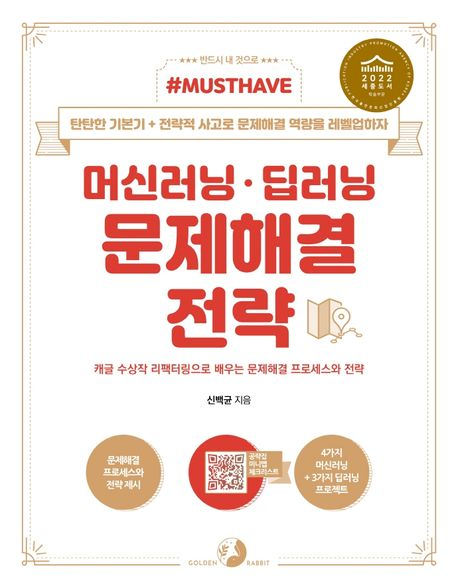

https://www.kaggle.com/competitions/aerial-cactus-identification/overview   
Code study of 'werooring'

# EDA

In [1]:
import pandas as pd

path = '/content/drive/MyDrive/2024Summer Self Study/Kaggle'

labels = pd.read_csv(path + '/train.csv')
labels = pd.DataFrame(labels)
submissions = pd.read_csv(path + '/sample_submission.csv')
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [ ]:
labels['has_cactus'].value_counts()

has_cactus
1    13136
0     4364
Name: count, dtype: int64

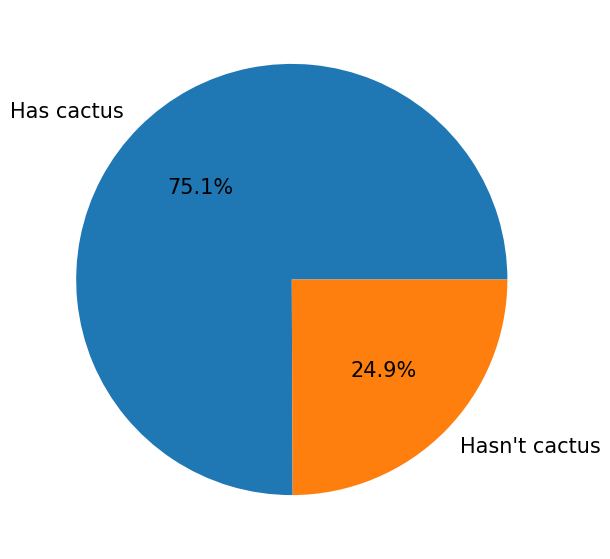

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Has cactus', 'Hasn\'t cactus'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f%%');

In [2]:
from zipfile import ZipFile

with ZipFile(path + '/train.zip', 'r') as z:
  z.extractall()

with ZipFile(path + '/test.zip', 'r') as z:
  z.extractall()

In [ ]:
import os
num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))
print('Number of training images:', num_train)
print('Number of testing images:', num_test)

Number of training images: 17500
Number of testing images: 4000


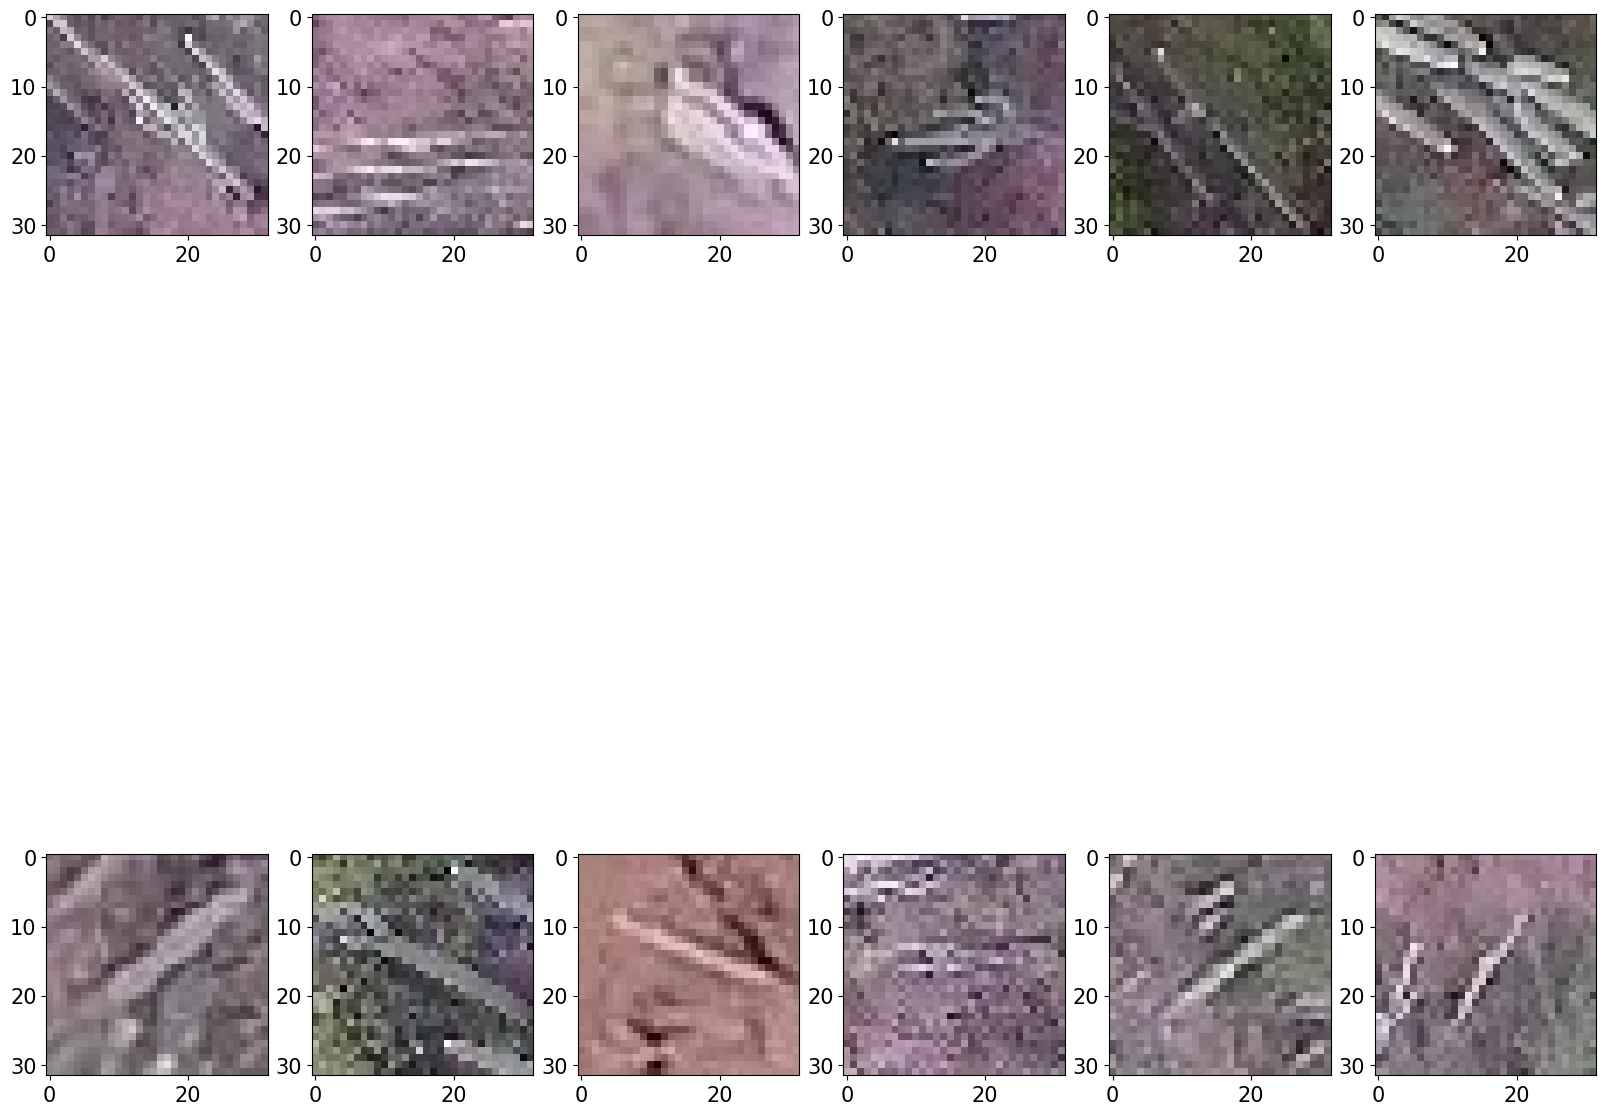

In [ ]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=15)
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2,6) # subplot(2,6)

cac_img = labels[labels['has_cactus'] == 1]['id'][-12:]

for idx, img_name in enumerate(cac_img):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(gs[idx])
    ax.imshow(image)

# Model

In [3]:
import torch
import random
import numpy as np
import os

seed = 50

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(labels, test_size=0.1, stratify=labels['has_cactus'], random_state=seed)

## DataSet

In [6]:
import cv2
from torch.utils.data import Dataset

class ImageDataset(Dataset):
  def __init__(self, df, img_dir = './', transform = None):
    super().__init__()
    self.df = df
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_id = self.df.iloc[idx, 0]
    img_path = self.img_dir + img_id
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = self.df.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    return image, label

In [7]:
from torchvision import transforms

transform = transforms.ToTensor() # image to tensor

In [8]:
dataset_train = ImageDataset(train, './train/', transform)
dataset_valid = ImageDataset(valid, './train/', transform)

## Data Loader

In [9]:
from torch.utils.data import DataLoader

# Set data loader seed to get the same result all the time
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, worker_init_fn=seed_worker,generator= g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False, worker_init_fn=seed_worker,generator= g, num_workers=2)

## Baseline Model

In [29]:
loader_train.dataset[0][0].shape

torch.Size([3, 32, 32])

### Set

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  # define layers
  def __init__(self):
    super().__init__()

    # fist convolution layer
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
    # second convulutio layer
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
    # Max pooling layer
    self.max_pool = nn.MaxPool2d(kernel_size = 2)
    # avg pooling layer
    self.avg_pool = nn.AvgPool2d(kernel_size = 2)
    # fully connected layer
    self.fc = nn.Linear(in_features=64*4*4, out_features=2)

  # Use the defined layers
  # forward
  def forward(self, x):
    x = self.max_pool(F.relu(self.conv1(x)))
    x = self.max_pool(F.relu(self.conv2(x)))
    x = self.avg_pool(x)
    x = x.view(-1, 64*4*4) #flatten
    x = self.fc(x)
    return x

3,32,32 -(conv1 & maxpool)> 32,17,17-(conv2 & maxpool)> 64,9,9-(avg pool)>  in_features=64*4*4 -(flatten)> 1024 -(fc)> result:2 probability of 0 or 1   
  
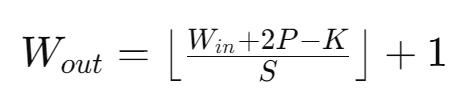


In [31]:
model = Model().to(device)
model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

### Train

In [34]:
# @title Loss Function
criterion = nn.CrossEntropyLoss()

In [35]:
# @title Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# will fine tune model parameters.

In [39]:
import math
print('iteration in 1 epoch:',math.ceil(len(train) / 32))
print('Same as data loader length,', len(loader_train))

iteration in 1 epoch: 493
Same as data loader length, 493


In [40]:
epochs = 10

for epoch in range(epochs):
  epoch_loss = 0 # initialize every epoch

  for images, labels in loader_train:
    images = images.to(device)
    labels = labels.to(device)

    # initialize gradient in optimizer
    optimizer.zero_grad()

    # forward
    outputs = model(images)

    # loss
    loss = criterion(outputs, labels)
    epoch_loss += loss.item()

    # backward
    loss.backward()

    # update
    optimizer.step()

  print(f'Epoch [{epoch+1}/{epochs}] loss: {epoch_loss/len(loader_train):.4f}')

Epoch [1/10] loss: 0.5230
Epoch [2/10] loss: 0.3416
Epoch [3/10] loss: 0.2409
Epoch [4/10] loss: 0.2010
Epoch [5/10] loss: 0.1755
Epoch [6/10] loss: 0.1598
Epoch [7/10] loss: 0.1514
Epoch [8/10] loss: 0.1430
Epoch [9/10] loss: 0.1335
Epoch [10/10] loss: 0.1322


### Validate: ROC, AUC

In [41]:
from sklearn.metrics import roc_auc_score

true_list = []
preds_list = []

In [42]:
model.eval() # evaluation mode

with torch.no_grad(): # stop gradient update
  for images, labels in loader_valid: # validation data
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    preds = torch.softmax(outputs.cpu(), dim=1)[:,1] # probability predicted
    true = labels.cpu()

    true_list.extend(true)
    preds_list.extend(preds)

print(f'ROC AUC score: {roc_auc_score(true_list, preds_list):.4f}')

ROC AUC score: 0.9894


### Test

In [45]:
dataset_test = ImageDataset(df = submissions, img_dir= 'test/', transform= transform)
loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [47]:
model.eval()

preds = []

with torch.no_grad():
  for images, _ in loader_test:
    images = images.to(device)

    outputs = model(images)

    preds_part = torch.softmax(outputs.cpu(), dim=1)[:,1].tolist()
    preds.extend(preds_part)

In [48]:
submissions['has_cactus'] = preds
submissions.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.996224
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.999983
2,001ee6d8564003107853118ab87df407.jpg,0.334076
3,002e175c3c1e060769475f52182583d0.jpg,0.482743
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.965797


In [49]:
# delete file

import shutil
shutil.rmtree('./train')
shutil.rmtree('./test')

## Enhance Model

### Data Augmentation

In [10]:
from torchvision import transforms

# Split train transform and test transform
# Test data remains to be similar to original img
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode = 'symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Pad(32, padding_mode = 'symmetric'),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [12]:
# Image transformer is applied to DataLoader
# So, each poch the model gets randomly transformed version of Img
dataset_train = ImageDataset(train, './train/', transform_train)
dataset_valid = ImageDataset(valid, './train/', transform_test)

from torch.utils.data import DataLoader

loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False)

### Set
- Deeper Layer
- Batch Normalization
- Leaky ReLU activation function

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  # define layers
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2)) # batch32* (3,96,96) Img with padding
    self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2),
                                nn.BatchNorm2d(512),
                                nn.LeakyReLU(),
                                nn.MaxPool2d(kernel_size = 2))
    self.avg_pool = nn.AvgPool2d(kernel_size = 4)
    self.fc1 = nn.Linear(in_features=512*1*1, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=2)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.avg_pool(x)
    x = x.view(-1, 512*1*1) #flatten
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [16]:
model = Model().to(device)

### Train

In [17]:
# @title Loss Function
criterion = nn.CrossEntropyLoss()

In [18]:
# @title Optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

In [19]:
# More data, so we can run more epochs
epochs = 70

for epoch in range(epochs):
  epoch_loss = 0 # initialize every epoch

  for images, labels in loader_train:
    images = images.to(device)
    labels = labels.to(device)

    # initialize gradient in optimizer
    optimizer.zero_grad()

    # forward
    outputs = model(images)

    # loss
    loss = criterion(outputs, labels)
    epoch_loss += loss.item()

    # backward
    loss.backward()

    # update weight
    optimizer.step()

  print(f'Epoch [{epoch+1}/{epochs}] loss: {epoch_loss/len(loader_train):.4f}')

Epoch [1/70] loss: 0.1287
Epoch [2/70] loss: 0.0657
Epoch [3/70] loss: 0.0480
Epoch [4/70] loss: 0.0416
Epoch [5/70] loss: 0.0337
Epoch [6/70] loss: 0.0346
Epoch [7/70] loss: 0.0314
Epoch [8/70] loss: 0.0270
Epoch [9/70] loss: 0.0251
Epoch [10/70] loss: 0.0260
Epoch [11/70] loss: 0.0228
Epoch [12/70] loss: 0.0228
Epoch [13/70] loss: 0.0195
Epoch [14/70] loss: 0.0206
Epoch [15/70] loss: 0.0200
Epoch [16/70] loss: 0.0172
Epoch [17/70] loss: 0.0158
Epoch [18/70] loss: 0.0171
Epoch [19/70] loss: 0.0164
Epoch [20/70] loss: 0.0162
Epoch [21/70] loss: 0.0137
Epoch [22/70] loss: 0.0147
Epoch [23/70] loss: 0.0124
Epoch [24/70] loss: 0.0116
Epoch [25/70] loss: 0.0136
Epoch [26/70] loss: 0.0113
Epoch [27/70] loss: 0.0123
Epoch [28/70] loss: 0.0127
Epoch [29/70] loss: 0.0114
Epoch [30/70] loss: 0.0111
Epoch [31/70] loss: 0.0096
Epoch [32/70] loss: 0.0097
Epoch [33/70] loss: 0.0100
Epoch [34/70] loss: 0.0100
Epoch [35/70] loss: 0.0091
Epoch [36/70] loss: 0.0097
Epoch [37/70] loss: 0.0074
Epoch [38/

KeyboardInterrupt: 

### Validate: ROC, AUC

In [20]:
from sklearn.metrics import roc_auc_score

true_list = []
preds_list = []

In [21]:
model.eval() # evaluation mode

with torch.no_grad(): # stop gradient update
  for images, labels in loader_valid: # validation data
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    preds = torch.softmax(outputs.cpu(), dim=1)[:,1] # probability predicted
    true = labels.cpu()

    true_list.extend(true)
    preds_list.extend(preds)

print(f'ROC AUC score: {roc_auc_score(true_list, preds_list):.4f}')

ROC AUC score: 0.9997


### Test

In [22]:
dataset_test = ImageDataset(df = submissions, img_dir= 'test/', transform= transform_test)
loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [23]:
model.eval()

preds = []

with torch.no_grad():
  for images, _ in loader_test:
    images = images.to(device)

    outputs = model(images)

    preds_part = torch.softmax(outputs.cpu(), dim=1)[:,1].tolist()
    preds.extend(preds_part)

In [24]:
submissions['has_cactus'] = preds
submissions.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1.000000
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.000000
2,001ee6d8564003107853118ab87df407.jpg,0.000021
3,002e175c3c1e060769475f52182583d0.jpg,0.000014
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.721631


In [25]:
# delete file

import shutil
shutil.rmtree('./train')
shutil.rmtree('./test')